<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2_complexes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold2_complexes

Credit to Minkyung Baek @minkbaek and Yoshitaka Moriwaki @Ag_smith for initially showing protein-complex prediction works in alphafold2.
- https://twitter.com/minkbaek/status/1417538291709071362
- https://twitter.com/Ag_smith/status/1417063635000598528

- [script](https://github.com/RosettaCommons/RoseTTAFold/blob/main/example/complex_modeling/make_joint_MSA_bacterial.py) from rosettafold for paired alignment generation

**Instructions**
- For *monomers* and *homo-oligomers*, see this [notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).
- For prokaryotic protein complexes (found in operons), we recommend using the `pair_msa` option with `disable_mmseqs2_filter`.


**Limitations**
- This notebook does not use templates or Amber refinement at the end.
- For a typical Google-Colab-GPU (16G) session, the max total length is **1400 residues**.


In [1]:
#@title Input protein sequences
import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from google.colab import files
import os.path
import re

import hashlib
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]


query_sequence_a = 'AVLKIIQGALDTRELLKAYQEEACAKNFGAFCVFVGIVRKEDNIQGLSFDIYEALLKTWFEKWHHKAKDLGVVLKMAHSLGDVLIGQSSFLCVSMGKNRKNALELYENFIEDFKHNAPIWKYDLIHNKRIYAKERSHPLKGSGLLA' #@param {type:"string"}
query_sequence_a = "".join(query_sequence_a.split())
query_sequence_a = re.sub(r'[^A-Z]','', query_sequence_a.upper())

query_sequence_b = 'MMVEVRFFGPIKEENFFIKANDLKELRAILQEKEGLKEWLGVCAIALNDHLIDNLNTPLKDGDVISLLPPVCGG' #@param {type:"string"}
query_sequence_b = "".join(query_sequence_b.split())
query_sequence_b = re.sub(r'[^A-Z]','', query_sequence_b.upper())

# Using trick from @onoda_hiroki
# https://twitter.com/onoda_hiroki/status/1420068104239910915
# "U" indicates an "UNKNOWN" residue and it will not be modeled
# But we need linker of at least length 32
query_sequence_a = re.sub(r'U+',"U"*32,query_sequence_a)
query_sequence_b = re.sub(r'U+',"U"*32,query_sequence_b)

query_sequence = query_sequence_a + query_sequence_b

if len(query_sequence) > 1400:
  print(f"WARNING: For a typical Google-Colab-GPU (16G) session, the max total length is 1400 residues. You are at {len(query_sequence)}!")

jobname = 'test' #@param {type:"string"}
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)

with open(f"{jobname}_a.fasta", "w") as text_file:
  text_file.write(">1\n%s" % query_sequence_a)

with open(f"{jobname}_b.fasta", "w") as text_file:
  text_file.write(">1\n%s" % query_sequence_b)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
msa_mode = "MMseqs2" #@param ["MMseqs2","single_sequence"]
use_msa = True if msa_mode == "MMseqs2" else False
disable_mmseqs2_filter = False #@param {type:"boolean"}
pair_msa = False #@param {type:"boolean"}

#@markdown ---
with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("pair_msa=%s\n" % pair_msa)
    text_file.write("disable_mmseqs2_filter=%s\n" % disable_mmseqs2_filter)

# decide which a3m to use
if use_msa:
  if disable_mmseqs2_filter:
    a3m_file_a = f"{jobname}_a.nofilter.a3m"
    a3m_file_b = f"{jobname}_b.nofilter.a3m"
  else:
    a3m_file_a = f"{jobname}_a.a3m"
    a3m_file_b = f"{jobname}_b.a3m"

In [2]:
#@title Install dependencies
%%bash -s $use_msa
USE_MSA=$1
if [ ! -f AF2_READY ]; then

  # install dependencies
  pip -q install biopython
  pip -q install dm-haiku
  pip -q install ml-collections
  pip -q install py3Dmol

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi

  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    wget -qnc https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar
    mkdir params
    tar -xf alphafold_params_2021-07-14.tar -C params/
    rm alphafold_params_2021-07-14.tar
  fi
  touch AF2_READY
fi
# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi

In [3]:
#@title Import libraries
# setup the model
if "model" not in dir():

  # hiding warning messages
  import warnings
  from absl import logging
  import os
  import tensorflow as tf
  warnings.filterwarnings('ignore')
  logging.set_verbosity("error")
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')

  import sys
  import numpy as np
  import pickle
  from string import ascii_uppercase
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, random_seed=0, num_models=5):  
  """Predicts structure using AlphaFold for the given sequence."""
  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
    idx_res[L_prev+L_i:] += 200
    L_prev += L_i  
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts = []
  paes = []
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  model_names = ["model_4","model_1","model_2","model_3","model_5"][:num_models]
  for n,model_name in enumerate(model_names):
    model_config = config.model_config(model_name+"_ptm")
    model_config.data.eval.num_ensemble = 1
    model_params = data.get_model_haiku_params(model_name+"_ptm", data_dir=".")

    if model_name == "model_4":
      model_runner = model.RunModel(model_config, model_params)
      processed_feature_dict = model_runner.process_features(feature_dict,random_seed=0)
    else:
      # swap params
      for k in model_runner.params.keys():
        model_runner.params[k] = model_params[k]

    print(f"running model_{n+1}")
    prediction_result = model_runner.predict(processed_feature_dict)

    # cleanup to save memory
    if model_name == "model_5": del model_runner
    del model_params
    
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
    plddts.append(prediction_result['plddt'])
    paes.append(prediction_result['predicted_aligned_error'])

    # Delete unused outputs to save memory.
    del prediction_result

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  plddts_ranked = {}
  paes_ranked = {}
  print("model\tplldt\tpae_ab")
  L = Ls[0]
  for n,r in enumerate(lddt_rank):
    plddt = plddts[r].mean()
    pae_ab = (paes[r][L:,:L].mean() + paes[r][:L,L:].mean()) / 2
    print(f"model_{n+1}\t{plddt:.2f}\t{pae_ab:.2f}")
    
    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path, plddts[r], idx_res, chains)

    plddts_ranked[f"model_{n+1}"] = plddts[r]
    paes_ranked[f"model_{n+1}"] = paes[r]

  return plddts_ranked, paes_ranked

##################################
# CODE FROM MINKYUNG/ROSETTAFOLD
##################################
def read_a3m(fn):
    '''parse an a3m files as a dictionary {label->sequence}'''
    seq = []
    lab = []
    is_first = True
    for line in open(fn, "r"):
        if line[0] == '>':
            label = line.strip()[1:]
            is_incl = True
            if is_first: # include first sequence (query)
                is_first = False
                lab.append(label)
                continue
            if "UniRef" in label:
                code = label.split()[0].split('_')[-1]
                if code.startswith("UPI"): # UniParc identifier -- exclude
                    is_incl = False
                    continue
            elif label.startswith("tr|"):
                code = label.split('|')[1]
            else:
                is_incl = False
                continue
            lab.append(code)
        else:
            if is_incl:
                seq.append(line.rstrip())
            else:
                continue
    return seq, lab

# https://www.uniprot.org/help/accession_numbers
def uni2idx(ids):
    '''convert uniprot ids into integers according to the structure
    of uniprot accession numbers'''
    ids2 = [i.split("-")[0] for i in ids]
    ids2 = [i+'AAA0' if len(i)==6 else i for i in ids2]
    arr = np.array([list(s) for s in ids2], dtype='|S1').view(np.uint8)

    for i in [1,5,9]:
        arr[:,i] -= ord('0')

    arr[arr>=ord('A')] -= ord('A')
    arr[arr>=ord('0')] -= ord('0')-26

    arr[:,0][arr[:,0]>ord('Q')-ord('A')] -= 3

    arr = arr.astype(np.int64)

    coef = np.array([23,10,26,36,36,10,26,36,36,1], dtype=np.int64)
    coef = np.tile(coef[None,:],[len(ids),1])

    c1 = [i for i,id_ in enumerate(ids) if id_[0] in 'OPQ' and len(id_)==6]
    c2 = [i for i,id_ in enumerate(ids) if id_[0] not in 'OPQ' and len(id_)==6]

    coef[c1] = np.array([3, 10,36,36,36,1,1,1,1,1])
    coef[c2] = np.array([23,10,26,36,36,1,1,1,1,1])

    for i in range(1,10):
        coef[:,-i-1] *= coef[:,-i]

    return np.sum(arr*coef,axis=-1)

In [4]:
#@title Call MMseqs2 to get MSA for each gene  
%%bash -s $use_msa $jobname $disable_mmseqs2_filter
USE_MSA=$1
JOBNAME=$2
NOFILTER=$3
if [ ${USE_MSA} == "True" ]; then
  for C in "a" "b"
  do
    if [ ${NOFILTER} == "True" ]; then
      RESULT=${JOBNAME}_${C}.mmseqs2.nofilter.tar.gz
      RESULT_A3M=${JOBNAME}_${C}.nofilter.a3m
    else
      RESULT=${JOBNAME}_${C}.mmseqs2.tar.gz
      RESULT_A3M=${JOBNAME}_${C}.a3m
    fi
    if [ ! -f RESULT ]; then
      # query MMseqs2 webserver
      echo "submitting job"
      if [ ${NOFILTER} == "True" ]; then
        ID=$(curl -s -F q=@${JOBNAME}_${C}.fasta -F mode=nofilter https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
      else
        ID=$(curl -s -F q=@${JOBNAME}_${C}.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
      fi
      STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
      while [ "${STATUS}" == "RUNNING" ]; do
        STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
        sleep 1
      done
      if [ "${STATUS}" == "COMPLETE" ]; then
        curl -s https://a3m.mmseqs.com/result/download/${ID} > ${RESULT}
        tar xzf ${RESULT}
        tr -d '\000' < uniref.a3m > ${RESULT_A3M}
        rm uniref.a3m
        mv pdb70.m8 ${JOBNAME}_${C}.m8
      else
        echo "MMseqs2 server did not return a valid result."
        cp ${JOBNAME}_${C}.fasta ${RESULT_A3M}
      fi
    fi
    if [ ${USE_MSA} == "True" ]; then
      echo "Found $(grep -c ">" ${RESULT_A3M}) sequences"
    fi
  done
fi

submitting job
Found 225 sequences
submitting job
Found 232 sequences


In [5]:
#@title Gather input features, predict structure

Ls = [len(query_sequence_a),len(query_sequence_b)]
msas = []
deletion_matrices = []

# parse MSA
if use_msa:
  
  # MSA_AB
  if pair_msa:
    ###########################################################################
    # CODE FROM MINKYUNG/ROSETTAFOLD
    ###########################################################################
    msa1, lab1 = read_a3m(a3m_file_a)
    msa2, lab2 = read_a3m(a3m_file_b)
    if len(lab1) > 1 and len(lab2) > 1:
      # convert uniprot ids into integers
      hash1 = uni2idx(lab1[1:])
      hash2 = uni2idx(lab2[1:])

      # find pairs of uniprot ids which are separated by at most 10
      idx1, idx2 = np.where(np.abs(hash1[:,None]-hash2[None,:]) < 10)
      if idx1.shape[0] > 0:
        a3m_lines = ['>query\n%s%s\n'%(msa1[0],msa2[0])]
        for i,j in zip(idx1,idx2):
          a3m_lines.append(">%s_%s\n%s%s\n"%(lab1[i+1],lab2[j+1],msa1[i+1],msa2[j+1]))
        
        msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(a3m_lines))
        msas.append(msa)
        deletion_matrices.append(deletion_matrix)

        print("pairs found:",len(msa))

  # MSA_A
  a3m_lines = "".join(open(a3m_file_a,"r").readlines())
  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
  msas.append([seq+"-"*Ls[1] for seq in msa])
  deletion_matrices.append([mtx+[0]*Ls[1] for mtx in deletion_matrix])

  # MSA_B
  a3m_lines = "".join(open(a3m_file_b,"r").readlines())
  msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)
  msas.append(["-"*Ls[0]+seq for seq in msa])
  deletion_matrices.append([[0]*Ls[0]+mtx for mtx in deletion_matrix])
else:
  msas.append([query_sequence])
  deletion_matrices.append([[0]*len(query_sequence)])

# gather features
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=msas, deletion_matrices=deletion_matrices),
}
plddts, paes = predict_structure(jobname, feature_dict, Ls=Ls, num_models=num_models)

running model_1
running model_2
running model_3
running model_4
running model_5
model	plldt	pae_ab
model_1	96.38	4.02
model_2	96.15	4.11
model_3	95.92	4.01
model_4	95.81	4.22
model_5	95.79	4.06


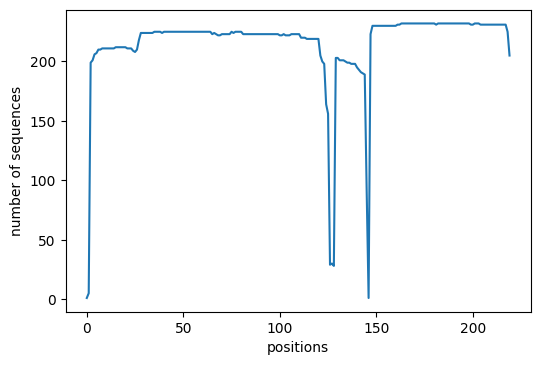

In [6]:
#@title Plot Number of Sequences per Position
dpi =  100#@param {type:"integer"}
# confidence per position
plt.figure(dpi=dpi)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.savefig(jobname+"_msa_coverage.png")
plt.show()

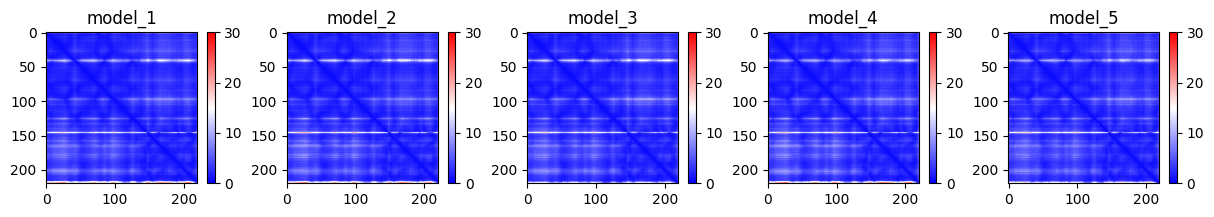

In [7]:
#@title Plot Predicted Alignment Error
dpi =  100#@param {type:"integer"}

# confidence per position
plt.figure(figsize=(3*num_models,2), dpi=dpi)
for n,(model_name,value) in enumerate(paes.items()):
  plt.subplot(1,num_models,n+1)
  plt.title(model_name)
  plt.imshow(value,label=model_name,cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
plt.savefig(jobname+"_PAE.png")
plt.show()

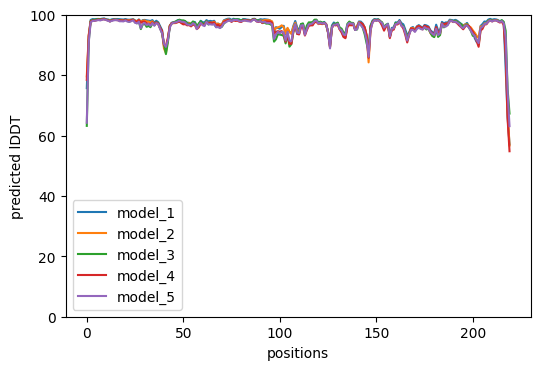

In [8]:
#@title Plot lDDT per residue
# confidence per position
dpi =  100#@param {type:"integer"}
plt.figure(dpi=dpi)
for model_name,value in plddts.items():
  plt.plot(value,label=model_name)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted lDDT")
plt.xlabel("positions")
plt.savefig(jobname+"_lDDT.png")
plt.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

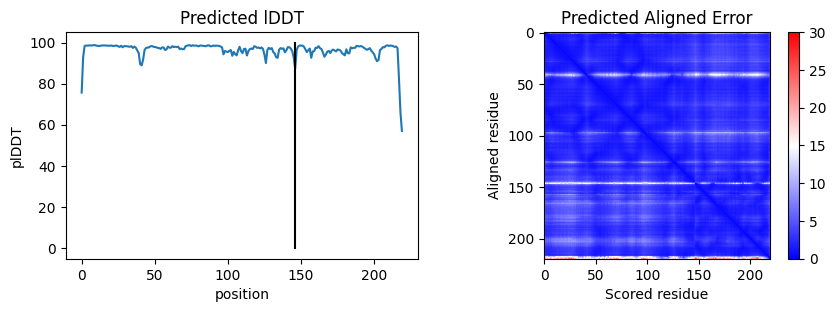

In [16]:
#@title Display 3D structure {run: "auto"}
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "chain" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_num=1):
  model_name = f"model_{model_num}"
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(plddts[model_name])
  for x in [len(query_sequence_a)]:
    plt.plot([x,x],[0,100],color="black")

  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(paes[model_name], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(model_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"model_{model_num}"
  pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(2),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(model_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()  
plot_confidence(model_num).show()

In [10]:
#@title Package and download results
!zip -FSr $jobname".result.zip" $jobname".log" $jobname"_msa_coverage.png" $jobname"_"*"relaxed_model_"*".pdb" $jobname"_lDDT.png"  $jobname"_PAE.png"
files.download(f"{jobname}.result.zip")

  adding: test_90446.log (deflated 17%)
  adding: test_90446_msa_coverage.png (deflated 8%)
  adding: test_90446_unrelaxed_model_1.pdb (deflated 78%)
  adding: test_90446_unrelaxed_model_2.pdb (deflated 78%)
  adding: test_90446_unrelaxed_model_3.pdb (deflated 78%)
  adding: test_90446_unrelaxed_model_4.pdb (deflated 78%)
  adding: test_90446_unrelaxed_model_5.pdb (deflated 78%)
  adding: test_90446_lDDT.png (deflated 7%)
  adding: test_90446_PAE.png (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions
- If you having issues downloading results, try disable adblocker and run the last cell again. If that fails click on the little folder icon to the left, navigate to file:`jobname.result.zip`, right-click and select "download".